In [1]:
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#define amount of sample points
N = 2000

In [3]:
def thermal_conductivity_equation(x):
    return (2 + torch.exp(-4*(torch.pi**2)*x[0])*torch.sin(2*torch.pi*x[1]) + torch.exp(-16*(torch.pi**2)*x[0])*torch.cos(4*torch.pi*x[1]))

# function depicting a real graph and a predicted one
def check_current_situation(cur_model):
    x = torch.linspace(0, 1, 100)
    time = torch.zeros(100)
    real_temp = thermal_conductivity_equation([time, x])

    test_points = torch.stack((x, time), axis = -1)

    pinn_temp = cur_model(test_points)

    plt.plot(x.detach(), pinn_temp.detach())
    plt.plot(x, real_temp)

    plt.plot()
    plt.show()

In [4]:
x_physics = torch.rand(N).requires_grad_(True)
time_physics = 0.05 * torch.rand(N).requires_grad_(True)

points_for_pinn_model = torch.stack((time_physics, x_physics), -1)
boundary_condition_points = torch.stack((torch.zeros(N), x_physics), -1)

torch.manual_seed(123)
thermal_conductivity_equation([time_physics, x_physics])

tensor([2.0716, 2.4076, 2.5056,  ..., 2.0316, 1.4441, 2.4639],
       grad_fn=<AddBackward0>)

In [5]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 2, hidden_layer = 64, number_layers = 3, output_layer = 1):
        super().__init__()
        
        activation = nn.Tanh
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x

In [6]:
pinn_model = PINN()
optimizer = torch.optim.SGD(pinn_model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(pinn_model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5000, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor = 0.7)

epoch: 20000	loss: (7.878056526184082, 3.532837152481079, 4.343987464904785, 0.0012319127563387156)	


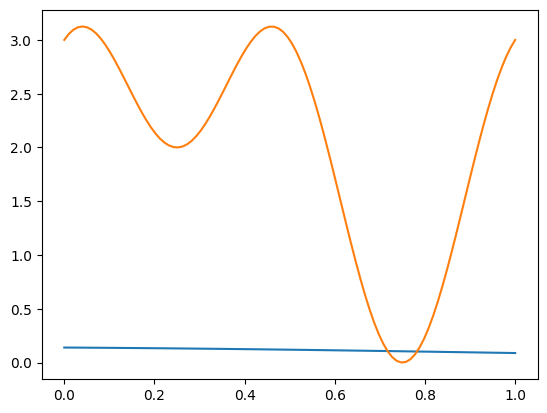

epoch: 20250	loss: (1.0839478969573975, 0.13513357937335968, 0.9427793622016907, 0.006035015918314457)	
epoch: 20500	loss: (0.9685666561126709, 0.10466913878917694, 0.8467946648597717, 0.017102854326367378)	
epoch: 20750	loss: (0.9213511943817139, 0.09726487845182419, 0.793715238571167, 0.030371040105819702)	
epoch: 21000	loss: (0.9029622077941895, 0.09800145030021667, 0.7698875069618225, 0.035073257982730865)	


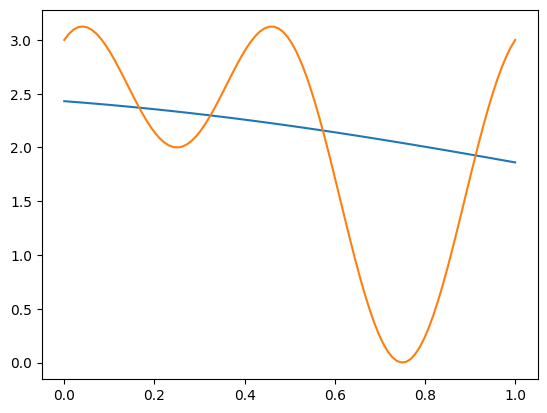

epoch: 21250	loss: (0.8916966319084167, 0.09977499395608902, 0.7585593461990356, 0.033362261950969696)	
epoch: 21500	loss: (0.8827419877052307, 0.10142811387777328, 0.7517977356910706, 0.02951613813638687)	
epoch: 21750	loss: (0.8751943707466125, 0.102963887155056, 0.7468814253807068, 0.025349056348204613)	
epoch: 22000	loss: (0.8687520623207092, 0.10443933308124542, 0.7429010272026062, 0.02141168899834156)	


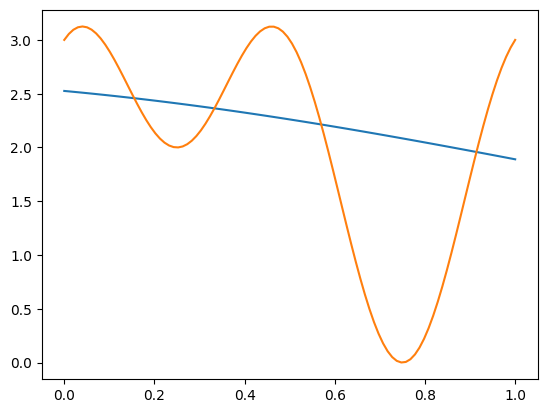

epoch: 22250	loss: (0.8632453083992004, 0.10587288439273834, 0.7395186424255371, 0.017853790894150734)	
epoch: 22500	loss: (0.8585565090179443, 0.10726141184568405, 0.736585259437561, 0.014709847047924995)	
epoch: 22750	loss: (0.8545930981636047, 0.10859362781047821, 0.7340204119682312, 0.011979026719927788)	
epoch: 23000	loss: (0.8512740731239319, 0.10985628515481949, 0.7317718863487244, 0.009645882062613964)	


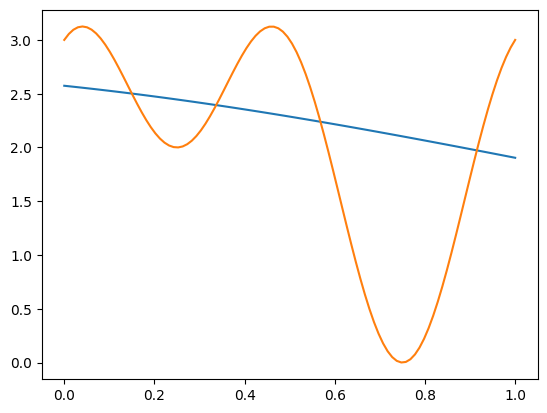

KeyboardInterrupt: 

In [7]:
epochs = 20000


for cur_epoch in range(epochs):
    optimizer.zero_grad()
    
    boundary_condition_temp = pinn_model(boundary_condition_points)
    network_temp = pinn_model(points_for_pinn_model)
    
    # compute the "data loss"
    loss1 = torch.mean((thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - network_temp)**2)
    loss2 = torch.mean((thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1) - boundary_condition_temp)**2)
    
    network_temp = pinn_model(points_for_pinn_model)
    
    dt = torch.autograd.grad(network_temp, time_physics, torch.ones_like(network_temp), create_graph=True)[0]

    # computes dy/dx
    dx = torch.autograd.grad(network_temp, x_physics, torch.ones_like(network_temp), create_graph=True)[0]
    
    # computes d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    
    # compute the "physics loss"
    loss3 = torch.mean((dt - dx2)**2)
    
    dist = loss1 + loss2 + loss3
    loss = 0.3 * loss1 + 0.5 * loss2 + 0.2 * loss3
    loss.backward(retain_graph=True)
    
    optimizer.step()
    #scheduler.step(loss)
    if cur_epoch % 250 == 0:
        print(f'epoch: {20000+cur_epoch}\tloss: {float(loss.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy()), float(loss3.detach().numpy())}\t')
    if cur_epoch % 1000 == 0:
        check_current_situation(pinn_model) 

In [42]:
pinn_model(points_for_pinn_model)

tensor([[2.0062],
        [2.0194],
        [2.0054],
        ...,
        [2.0142],
        [2.0238],
        [2.0115]], grad_fn=<AddmmBackward0>)

In [47]:
torch.mean(thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - pinn_model(points_for_pinn_model))

tensor(-0.0220, grad_fn=<MeanBackward0>)

In [46]:
thermal_conductivity_equation([time_physics, x_physics]).view(-1,1)


tensor([[2.1422],
        [1.9769],
        [2.2335],
        ...,
        [1.8930],
        [2.6954],
        [1.9622]], grad_fn=<ViewBackward0>)

In [48]:
torch.zeros_like(x_physics)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [49]:
x_physics

tensor([0.2961, 0.5166, 0.2517,  ..., 0.9463, 0.4930, 0.9744],
       requires_grad=True)